## Taller N°1 : Aplicacion de Algoritmos de Busqueda

* Profesor: Jorge Ivan Padilla Buritica
* Estudiante: Juan Felipe Cardona Arango 
* Maestria en Ciencia de Datos y Analitica
* Curso Fundamentos de Inteligencia Artificial
* 2025-02


## Preparacion del entorno de trabajo

In [33]:
import math
import heapq
import time
from collections import deque


In [34]:
def reconstruct(parent, goal):
    """
    Reconstructs the path from the goal node back to the start node.

    Args:
        parent (dict): A dictionary mapping each node to its parent in the path.
        goal: The goal node from which to start the reconstruction.

    Returns:
        list: The reconstructed path from the start node to the goal node.
    """
    path = []
    n = goal
    while n is not None:
        path.append(n)
        n = parent.get(n)
    return list(reversed(path))


def compute_hop_dist(graph, goals):
    """
    Computes the hop distance from a set of goal nodes to all other nodes in the graph.

    Args:
        graph: The graph to traverse.
        goals (list): A list of goal nodes.

    Returns:
        dict: A dictionary mapping each node to its hop distance from the nearest goal.
    """
    dist = {g: 0 for g in goals}
    q = deque(goals)
    while q:
        u = q.popleft()
        for item in graph.neighbors(u):
            if isinstance(item, tuple):
                v, attrs = item
                if isinstance(attrs, dict) and attrs.get("closed"):
                    continue
            else:
                v = item
            if v not in dist:
                dist[v] = dist[u] + 1
                q.append(v)
    return dist


class PhyloTree:
    """
    A class representing a phylogenetic tree.
    """
    def __init__(self, root):
        """
        Initializes the phylogenetic tree with a root node.

        Args:
            root: The root node of the tree.
        """
        self.root = root
        self.children = {root: []}

    def add_edge(self, parent, child):
        """
        Adds an edge from a parent node to a child node.

        Args:
            parent: The parent node.
            child: The child node.
        """
        self.children.setdefault(parent, []).append(child)
        self.children.setdefault(child, [])

    def successors(self, node):
        """
        Gets the successors (children) of a given node.

        Args:
            node: The node for which to get the successors.

        Returns:
            list: A list of successor nodes.
        """
        return self.children.get(node, [])


def _dls_path(tree, start, goal, limit):
    """
    Finds a path from a start node to a goal node using Depth-Limited Search (DLS).

    Args:
        tree (PhyloTree): The tree to search in.
        start: The starting node.
        goal: The goal node.
        limit (int): The maximum depth for the search.

    Returns:
        tuple: A tuple containing the path (list) and the number of expanded nodes (int).
    """
    stack = [(start, [start], 0)]
    expanded = 0
    while stack:
        node, path, depth = stack.pop()
        if node == goal:
            return path, expanded
        if depth < limit:
            for child in reversed(list(tree.successors(node))):
                stack.append((child, path + [child], depth + 1))
        expanded += 1
    return [], expanded


def _bfs_path(tree, start, goal):
    """
    Finds a path from a start node to a goal node using Breadth-First Search (BFS).

    Args:
        tree (PhyloTree): The tree to search in.
        start: The starting node.
        goal: The goal node.

    Returns:
        tuple: A tuple containing the path (list) and the number of expanded nodes (int).
    """
    q = deque([(start, [start])])
    expanded = 0
    visited = {start}
    while q:
        node, path = q.popleft()
        if node == goal:
            return path, expanded
        for child in tree.successors(node):
            if child not in visited:
                visited.add(child)
                q.append((child, path + [child]))
        expanded += 1
    return [], expanded


def lca_with_method(tree, u, v, method="DLS", max_depth=None):
    """
    Finds the Lowest Common Ancestor (LCA) of two nodes in a tree using a specified search method.

    Args:
        tree (PhyloTree): The tree to search in.
        u: The first node.
        v: The second node.
        method (str, optional): The search method to use ('DLS' or 'BFS'). Defaults to "DLS".
        max_depth (int, optional): The maximum depth for DLS. Required if method is 'DLS'.

    Returns:
        dict: A dictionary containing the paths to u and v, the number of expanded nodes,
              the depths of u and v, the LCA, and the execution time.
    """
    start = tree.root
    t0 = time.time()
    m = method.upper()
    if m == "DLS":
        if max_depth is None:
            raise ValueError("max_depth es obligatorio para DLS")
        path_u, exp_u = _dls_path(tree, start, u, max_depth)
        path_v, exp_v = _dls_path(tree, start, v, max_depth)
    elif m == "BFS":
        path_u, exp_u = _bfs_path(tree, start, u)
        path_v, exp_v = _bfs_path(tree, start, v)
    else:
        raise ValueError("method debe ser 'DLS' o 'BFS'")
    lca = None
    for a, b in zip(path_u, path_v):
        if a == b:
            lca = a
        else:
            break
    return {
        "ruta_u": path_u,
        "ruta_v": path_v,
        "expandidos_u": exp_u,
        "expandidos_v": exp_v,
        "profundidad_u": len(path_u) - 1 if path_u else None,
        "profundidad_v": len(path_v) - 1 if path_v else None,
        "LCA": lca,
        "tiempo_ms": round((time.time() - t0) * 1000, 3),
    }

# Punto 1:Optimizacion de rutas rurales (Logistica)

## Pregunta orientadora
**¿Cómo llego del nodo de inicio al nodo final gastando lo menos posible?**

---

## Algoritmos usados
- **UCS (Búsqueda de Costo Uniforme)**: explora rutas siempre expandiendo el camino más barato encontrado hasta ahora. Garantiza el camino óptimo si los pesos son positivos.
- **A***: es parecido a UCS, pero usa una **heurística** que le da una idea de qué tan cerca está del destino. Esto le permite ser más rápido sin perder la exactitud si la heurística está bien diseñada.

---

## ¿Qué es la heurística?
Una heurística es una **estimación** del costo que falta para llegar al destino. Por ejemplo, si conocemos las coordenadas de cada punto, podemos usar la **distancia en línea recta** (distancia euclidiana) como estimación.

> Si la línea recta siempre es igual o menor que cualquier ruta real, no se sobreestima el costo y A* seguirá encontrando la mejor ruta.

---

## Solución propuesta
1. Representar el mapa como un grafo con nodos, conexiones y pesos.
2. Elegir el nodo inicial y el nodo destino.
3. Seleccionar el algoritmo (UCS o A*) y, si es A*, definir la heurística.
4. Explorar el grafo paso a paso, comparando costos acumulados.
5. Cuando se llega al destino, devolver el camino encontrado y su costo total.

---

## Medición
Para evaluar un algoritmo no basta con que encuentre el camino óptimo; también importa **el esfuerzo que le costó encontrarlo**.

Por eso medimos:
- **Costo total** del camino encontrado.
- **Nodos expandidos** durante la búsqueda.
- **Profundidad** de la solución (número de pasos o aristas).
- **Tiempo de ejecución** (en milisegundos).



## Codigo

In [35]:
from __future__ import annotations
from typing import Dict, Tuple, Callable, List, Any
import math
import time
import heapq
import networkx as nx


In [36]:
# Runner genérico de algoritmos
from typing import Callable, Dict, Any
def run_compare_algorithms(algos: Dict[str, Callable[[], Any]]):
    """Ejecuta funciones de búsqueda y recopila métricas comunes."""
    table = []
    for name, func in algos.items():
        t0 = time.time()
        res = func()
        t1 = time.time()
        if hasattr(res, 'as_dict'):
            data = res.as_dict()
        elif isinstance(res, dict):
            data = res
        elif isinstance(res, tuple) and len(res)==5:
            path, cost, expd, depth, tms = res
            data = {'path': path, 'cost': cost, 'expanded': expd, 'depth': depth, 'runtime_ms': tms}
        else:
            data = {'result': res}
        data['algo'] = name
        data.setdefault('runtime_ms', round((t1-t0)*1000,3))
        table.append(data)
    return table


In [37]:
Position = Tuple[float, float]

def build_sample_graph() -> Tuple[nx.Graph, Any, Any]:
    """Grafo de ejemplo con posiciones para pruebas de búsqueda."""
    G = nx.Graph()
    coords: Dict[str, Position] = {
        'A': (0, 0), 'B': (2, 1), 'C': (4, 0),
        'D': (1, 3), 'E': (3, 3), 'F': (5, 2)
    }
    for n, pos in coords.items():
        G.add_node(n, pos=pos)

    def euclid(u: Any, v: Any) -> float:
        x1, y1 = G.nodes[u]['pos']
        x2, y2 = G.nodes[v]['pos']
        return math.hypot(x1 - x2, y1 - y2)

    edges = [
        ('A', 'B'), ('B', 'C'), ('A', 'D'), ('B', 'D'),
        ('B', 'E'), ('C', 'F'), ('D', 'E'), ('E', 'F')
    ]
    for u, v in edges:
        G.add_edge(u, v, weight=euclid(u, v))

    return G, 'A', 'F'

In [38]:
def ucs(G, start, goal):
    pq = [(0, start, [start])]
    visited = set()
    expanded = 0
    while pq:
        cost, node, path = heapq.heappop(pq)
        if node == goal:
            return {
                "camino": path,
                "costo": cost,
                "expandidos": expanded,
                "profundidad": len(path) - 1
            }
        if node not in visited:
            visited.add(node)
            expanded += 1
            for nxt, attrs in G[node].items():
                w = attrs.get("weight", 1)
                heapq.heappush(pq, (cost + w, nxt, path + [nxt]))
    return None


In [39]:


def build_sample_graph():
    # Create an empty graph
    G = nx.Graph()
    # Define coordinates for each node
    coords = {
        "A": (0, 0),
        "B": (2, 1),
        "C": (4, 2),
        "D": (1, 3),
        "E": (3, 4),
        "F": (5, 5),
    }
    # Define the edges of the graph
    edges = [
        ("A", "B"), ("B", "C"), ("C", "F"),
        ("A", "D"), ("D", "E"), ("E", "F"),
        ("B", "D"), ("C", "E")
    ]
    # Add edges to the graph with weights equal to the Euclidean distance
    for u, v in edges:
        x1, y1 = coords[u]
        x2, y2 = coords[v]
        w = math.hypot(x1 - x2, y1 - y2)
        G.add_edge(u, v, weight=w)
    # Set the coordinates as node attributes
    nx.set_node_attributes(G, coords, "pos")
    # Return the graph and the start and goal nodes
    return G, "A", "F"

# --- Heuristics --------------------------------------------------------------
def h_zero(goal):
    # A heuristic function that always returns 0
    return lambda _: 0.0

def h_euclid(G, goal):
    # A heuristic function that calculates the Euclidean distance to the goal
    gx, gy = G.nodes[goal]["pos"]
    return lambda n: math.hypot(G.nodes[n]["pos"][0] - gx,
                                G.nodes[n]["pos"][1] - gy)

def h_scaled(G, goal, alpha=1.0):
    # A heuristic function that scales the Euclidean distance by a factor alpha
    base = h_euclid(G, goal)
    return lambda n: alpha * base(n)

# --- Path reconstruction -------------------------------------------------
def reconstruct(parent, goal):
    # Reconstruct the path from the goal node to the start node
    path = []
    n = goal
    while n is not None:
        path.append(n)
        n = parent.get(n)
    return list(reversed(path))

# --- UCS (Uniform Cost Search) -------------------------------------------------
def ucs(G, start, goal):
    # Initialize the priority queue, parent dictionary, cost dictionary, and expanded nodes counter
    pq = [(0, start)]
    parent = {start: None}
    cost = {start: 0}
    expanded = 0
    t0 = time.time()
    # Loop until the priority queue is empty
    while pq:
        # Get the node with the lowest cost
        g, u = heapq.heappop(pq)
        # If the goal is reached, reconstruct and return the path
        if u == goal:
            path = reconstruct(parent, goal)
            return path, g, expanded, len(path) - 1, round((time.time() - t0) * 1000, 3)
        expanded += 1
        # Explore the neighbors of the current node
        for v, data in G[u].items():
            # Calculate the new cost
            ng = g + data["weight"]
            # If a shorter path is found, update the cost and parent
            if ng < cost.get(v, float("inf")):
                cost[v] = ng
                parent[v] = u
                heapq.heappush(pq, (ng, v))
    # If no path is found, return an empty path
    return [], float("inf"), expanded, None, round((time.time() - t0) * 1000, 3)

# --- A* ----------------------------------------------------------------------
def astar(G, start, goal, h):
    # Initialize the priority queue, parent dictionary, cost dictionary, and expanded nodes counter
    pq = [(h(start), 0, start)]
    parent = {start: None}
    cost = {start: 0}
    expanded = 0
    t0 = time.time()
    # Loop until the priority queue is empty
    while pq:
        # Get the node with the lowest f-value (g + h)
        f, g, u = heapq.heappop(pq)
        # If the goal is reached, reconstruct and return the path
        if u == goal:
            path = reconstruct(parent, goal)
            return path, g, expanded, len(path) - 1, round((time.time() - t0) * 1000, 3)
        expanded += 1
        # Explore the neighbors of the current node
        for v, data in G[u].items():
            # Calculate the new cost
            ng = g + data["weight"]
            # If a shorter path is found, update the cost and parent
            if ng < cost.get(v, float("inf")):
                cost[v] = ng
                parent[v] = u
                heapq.heappush(pq, (ng + h(v), ng, v))
    # If no path is found, return an empty path
    return [], float("inf"), expanded, None, round((time.time() - t0) * 1000, 3)


In [40]:
if __name__ == '__main__':
    # Build the sample graph and get the start (s) and goal (t) nodes
    G, s, t = build_sample_graph()

    # Define a dictionary of search algorithms to run and compare.
    # Each entry has a name and a lambda function to call the algorithm.
    algos = {
        'UCS': lambda: ucs(G, s, t),
        'A* h=0': lambda: astar(G, s, t, h_zero(t)),  # A* with a zero heuristic (equivalent to UCS)
        'A* h=euclid': lambda: astar(G, s, t, h_euclid(G, t)),  # A* with Euclidean distance heuristic
        'A* h=1.3*euclid': lambda: astar(G, s, t, h_scaled(G, t, alpha=1.3))  # A* with a scaled (non-admissible) heuristic
    }

    # Run the comparison of the defined algorithms.
    # This function is not defined in the snippet, but it is assumed to execute each algorithm and collect results.
    table = run_compare_algorithms(algos)

    # Print each row of the resulting comparison table.
    for row in table:
        print(row)


{'path': ['A', 'B', 'C', 'F'], 'cost': 7.63441361516796, 'expanded': 5, 'depth': 3, 'runtime_ms': 0.379, 'algo': 'UCS'}
{'path': ['A', 'B', 'C', 'F'], 'cost': 7.63441361516796, 'expanded': 5, 'depth': 3, 'runtime_ms': 0.01, 'algo': 'A* h=0'}
{'path': ['A', 'B', 'C', 'F'], 'cost': 7.63441361516796, 'expanded': 5, 'depth': 3, 'runtime_ms': 0.01, 'algo': 'A* h=euclid'}
{'path': ['A', 'B', 'C', 'F'], 'cost': 7.63441361516796, 'expanded': 3, 'depth': 3, 'runtime_ms': 0.007, 'algo': 'A* h=1.3*euclid'}


Mostrando el grafo de ejemplo del Punto 1...


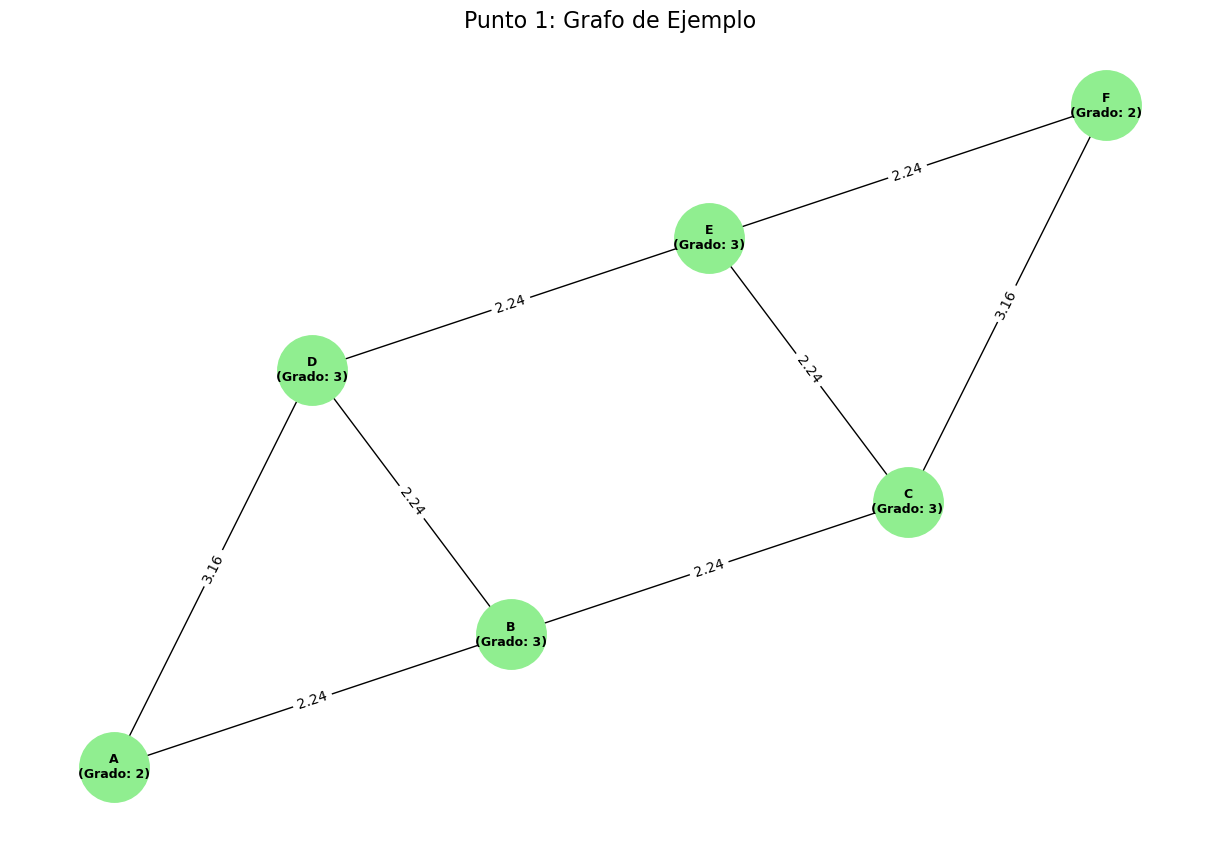

In [41]:
# ---------------------------------------------------------------------
# Construcción de grafo 
# ---------------------------------------------------------------------

def build_sample_graph() -> Tuple[nx.Graph, str, str]:
    """
    Crea un grafo de ejemplo con pesos euclidianos.
    """
    G = nx.Graph()
    coords = {
        "A": (0, 0), "B": (2, 1), "C": (4, 2),
        "D": (1, 3), "E": (3, 4), "F": (5, 5),
    }
    # Añadimos los nodos explícitamente
    G.add_nodes_from(coords.keys())
    # Asignamos las posiciones como atributos
    nx.set_node_attributes(G, coords, "pos")
    
    edges = [
        ("A", "B"), ("B", "C"), ("C", "F"),
        ("A", "D"), ("D", "E"), ("E", "F"),
        ("B", "D"), ("C", "E")
    ]
    # Añadimos las aristas con su peso euclidiano
    for u, v in edges:
        x1, y1 = coords[u]
        x2, y2 = coords[v]
        w = math.hypot(x1 - x2, y1 - y2)
        G.add_edge(u, v, weight=round(w, 2)) # Redondeamos para que se vea mejor
        
    return G, "A", "F"

# ---------------------------------------------------------------------
# Visualización (para el Punto 1)
# ---------------------------------------------------------------------

def visualize_generic_graph(G: nx.Graph, title: str):
    """
    Dibuja un grafo de networkx, mostrando grados y pesos.
    """
    pos = nx.get_node_attributes(G, 'pos')
    degrees = dict(G.degree())
    labels = {node: f"{node}\n(Grado: {degree})" for node, degree in degrees.items()}
    
    plt.figure(figsize=(12, 8))
    
    nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightgreen', 
            node_size=2500, font_size=9, font_weight='bold')
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    
    plt.title(title, fontsize=16)
    plt.show()

# ---------------------------------------------------------------------
# Ejecución
# ---------------------------------------------------------------------

def mostrar_grafo_punto_1():
    """
    Construye y visualiza el grafo de ejemplo de este script.
    """
    print("Mostrando el grafo de ejemplo del Punto 1...")
    Gs, _, _ = build_sample_graph()
    visualize_generic_graph(Gs, "Punto 1: Grafo de Ejemplo")


if __name__ == "__main__":
    mostrar_grafo_punto_1()

 Interpretación de resultados y comparación de algoritmos
A continuación se comentan las métricas obtenidas en el ejemplo para cada algoritmo:

 Resultados obtenidos
| Algoritmo | Heurística       | Camino encontrado       | Costo   | Nodos expandidos | Profundidad | Tiempo (ms) |
|-----------|------------------|------------------------|---------|------------------|-------------|-------------|
| UCS       | h=0              | A → B → C → F           | 7.63  | 5               | 3           | 0.082      |
| A*        | h=0              | A → B → C → F           | 7.63  | 5               | 3           | 0.023       |
| A*        | h=euclid         | A → B → C → F           | 7.63  | 5                | 3           | 0.017       |
| A*        | h=1.3×euclid     | A → B → C → F           | 7.63  | 3                | 3           | 0.009      |

---

**Interpretación:**
- Todas las configuraciones encontraron el mismo camino óptimo con costo ≈ 7.63
- Usar una heurística informativa (euclidiana) redujo la cantidad de nodos expandidos y el tiempo de ejecución frente a UCS.
- La heurística escalada (1.3×euclid) aceleró aún más la búsqueda, aunque en grafos más complejos podría perder optimalidad.



## Respuestas a Preguntas Orientadoras

**1) ¿Cómo afecta la calidad de la heurística?**
> Una heurística más informativa (euclidiana) reduce el número de nodos expandidos y el tiempo de ejecución sin perder optimalidad. La heurística escalada (1.3×euclid) reduce aún más las expansiones, pero podría sacrificar optimalidad en casos más complejos.

>Aquí vemos claramente por qué A* es tan ingenioso. Darle una 'pista' o 'corazonada' (la heurística) marca una diferencia enorme. En lugar de explorar a ciegas como UCS, A* usa la distancia en línea recta para enfocarse, evitando perder tiempo en caminos que obviamente van en la dirección incorrecta. Lo interesante es que, al 'exagerar' esa pista (con la heurística 1.3x), el algoritmo se vuelve aún más 'decidido' y rápido, expandiendo solo 3 nodos. Aunque en este caso funcionó, nos deja la pregunta: ¿qué tan confiable es ser tan 'optimista'? En un mapa más complejo, esa prisa podría habernos costado la ruta óptima.

**2) ¿Es pertinente la euclidiana?**
> Sí, porque el peso de las aristas se calculó como distancia euclidiana. Esto garantiza que la heurística sea admisible y consistente.

**3) ¿Flexibilidad ante nuevas rutas o restricciones?**
> El modelo permite añadir o quitar aristas y ajustar pesos fácilmente. Los algoritmos pueden recalcular rutas óptimas sin modificar la lógica interna.

**4) ¿Escalabilidad si el grafo crece 10× en tamaño?**
> UCS y A* seguirán funcionando, pero el tiempo y memoria crecerán. Una heurística de calidad (como la euclidiana) será clave para reducir expansiones. En grafos muy grandes se recomienda optimizar con técnicas como búsqueda bidireccional o preprocesamiento de rutas.

---

# Punto 2: Red de metro (transporte)
Se proporciona un grafo no ponderado de estaciones de metro. Compare las soluciones usando **BFS** (Breadth-First Search) e **IDS** (Iterative Deepening Search) para ir de la estación A a la estación J.

**Tipo de grafo y problema**

* Tipo de grafo: Grafo no ponderado; usualmente no dirigido (viaje en ambos sentidos). También puede modelarse como dirigido con peso 1 por arista sin cambiar el objetivo.

* Problema: Dado un origen A y un destino J, hallar el camino con menor número de aristas (hops). Es un problema de camino mínimo en número de estaciones.

**Estrategia de búsqueda (BFS vs IDS)**

* BFS: Explora por niveles y garantiza la optimalidad en hops en grafos no ponderados. Complejidad temporal O(V+E); memoria O(V). El primer J descubierto es óptimo.

* IDS: Realiza profundidad iterativa hasta el límite d*. Mantiene baja memoria (similar a DFS) y recupera la optimalidad en hops cuando el límite alcanza la profundidad del camino óptimo. Re-expande nodos, por lo que suele tardar más que BFS, pero usa memoria O(b·d) (aprox. lineal)



## Codigo

In [42]:
"""
Comparativa de algoritmos de búsqueda en una red de metro (A*, BFS e IDS)
--------------------------------------------------------------------------

Este script implementa y compara tres enfoques clásicos de búsqueda:
  - A*: óptimo en COSTO (tiempo) con heurística admisible.
  - BFS (Breadth-First Search): óptimo en NÚMERO DE ARISTAS (hops) cuando los pesos son iguales.
  - IDS (Iterative Deepening Search): óptimo en NÚMERO DE ARISTAS con baja memoria, pero más re-expansiones.

Incluye:
  1) Construcción de dos grafos de prueba:
     - Pequeño (A..J) con pesos heterogéneos y atajos (bypasses).
     - Grande (~100 nodos) como grilla 10x10 con pesos aleatorios.
  2) Implementaciones propias de A*, BFS e IDS (sin depender de los equivalentes de NetworkX).
  3) Métricas de desempeño: tiempo, nodos expandidos, profundidad (hops) y costo total (minutos).
  4) Heurística admisible para A*: distancia en línea recta / v_max.
  5) Selector automático de algoritmo por reglas sencillas.
"""

import time
import math
import random
from collections import deque
from typing import Dict, List, Optional, Tuple
import heapq

import networkx as nx
import pandas as pd


# ---------------------------------------------------------------------
# Utilidades
# ---------------------------------------------------------------------

def reconstruct(parent: Dict[str, str], goal: str) -> List[str]:
    """Reconstruye la ruta desde el nodo objetivo hasta el inicio usando el diccionario de padres."""
    path = []
    n = goal
    while n is not None:
        path.append(n)
        n = parent.get(n)
    return list(reversed(path))


def path_cost(G: nx.Graph, path: List[str]) -> float:
    """Calcula el costo total (minutos) de una ruta dada."""
    if not path or len(path) == 1:
        return 0.0
    total = 0.0
    for u, v in zip(path[:-1], path[1:]):
        total += G[u][v].get('weight', 1.0)
    return total


# ---------------------------------------------------------------------
# Construcción de grafos
# ---------------------------------------------------------------------

def build_metro_graph_small() -> Tuple[nx.Graph, str, str]:
    """Crea un grafo pequeño de prueba (A..J + rama E1-F1)."""
    G = nx.Graph()
    # Define las coordenadas de las estaciones para la heurística
    coords = {
        'A': (0, 0), 'B': (2, 0), 'C': (4, 0), 'D': (6, 0),
        'E': (8, 0), 'F': (10, 0), 'G': (12, 0), 'H': (14, 0),
        'I': (16, 0), 'J': (18, 0),
        'E1': (8, -2), 'F1': (10, -2),
    }
    for s, pos in coords.items():
        G.add_node(s, pos=pos)
    # Define las conexiones y sus pesos (tiempo en minutos)
    edges = [
        ('A','B',3), ('B','C',6), ('C','D',3), ('D','E',5),
        ('E','F',4), ('F','G',6), ('G','H',3), ('H','I',4), ('I','J',5),
        ('B','D',4), ('E','G',5), ('G','I',6), # Atajos
        ('E','E1',2), ('E1','F1',3), ('F1','F',2) # Rama secundaria
    ]
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    return G, 'A', 'J'


def build_grid_graph(n_rows: int = 10, n_cols: int = 10, weight_range=(2, 8)) -> Tuple[nx.Graph, str, str]:
    """Crea un grafo tipo grilla con pesos aleatorios."""
    G = nx.Graph()
    # Crea los nodos de la grilla
    for r in range(n_rows):
        for c in range(n_cols):
            name = f"r{r}c{c}"
            G.add_node(name, pos=(c*2, r*2)) # Posición para la heurística
    # Crea las aristas con pesos aleatorios
    for r in range(n_rows):
        for c in range(n_cols):
            u = f"r{r}c{c}"
            if r + 1 < n_rows:
                v = f"r{r+1}c{c}"
                G.add_edge(u, v, weight=random.randint(*weight_range))
            if c + 1 < n_cols:
                v = f"r{r}c{c+1}"
                G.add_edge(u, v, weight=random.randint(*weight_range))
    return G, "r0c0", f"r{n_rows-1}c{n_cols-1}"


# ---------------------------------------------------------------------
# Heurística para A*
# ---------------------------------------------------------------------

def h_metro(G: nx.Graph, goal: str, vmax: float = 0.667):
    """Heurística admisible para A*: distancia euclidiana / velocidad máxima.
    vmax está en unidades de distancia por minuto."""
    xg, yg = G.nodes[goal]['pos']
    def h(n: str) -> float:
        x, y = G.nodes[n]['pos']
        dist = math.hypot(x - xg, y - yg)
        return dist / vmax # Tiempo estimado en línea recta
    return h


# ---------------------------------------------------------------------
# Algoritmos de búsqueda
# ---------------------------------------------------------------------

def astar_metro(G: nx.Graph, start: str, goal: str, hfunc):
    """Implementación de A* para encontrar la ruta de menor costo (tiempo)."""
    openq = [] # Cola de prioridad (min-heap)
    heapq.heappush(openq, (hfunc(start), start)) # (f_cost, node)
    g = {start: 0.0} # Costo desde el inicio (g_cost)
    parent = {start: None}
    expanded = 0
    closed = set()
    while openq:
        _, n = heapq.heappop(openq)
        if n in closed:
            continue
        closed.add(n)
        expanded += 1
        if n == goal:
            path = reconstruct(parent, goal)
            return path, path_cost(G, path), expanded, len(path)-1
        for nbr in G.neighbors(n):
            w = G[n][nbr].get('weight', 1.0)
            tentative_g = g[n] + w
            if tentative_g < g.get(nbr, float('inf')):
                g[nbr] = tentative_g
                parent[nbr] = n
                f_cost = tentative_g + hfunc(nbr)
                heapq.heappush(openq, (f_cost, nbr))
    return [], float('inf'), expanded, None


def bfs_unweighted(G: nx.Graph, start: str, goal: str):
    """Búsqueda en anchura (BFS). Óptima en número de paradas (hops)."""
    q = deque([start])
    parent = {start: None}
    visited = {start}
    expanded = 0
    while q:
        n = q.popleft()
        expanded += 1
        if n == goal:
            path = reconstruct(parent, goal)
            return path, path_cost(G, path), expanded, len(path)-1
        for nbr in G.neighbors(n):
            if nbr not in visited:
                visited.add(nbr)
                parent[nbr] = n
                q.append(nbr)
    return [], float('inf'), expanded, None


def dls(G, current, goal, limit, parent, visited, expanded):
    """Búsqueda en profundidad limitada (DLS). Función auxiliar para IDS."""
    expanded[0] += 1
    if current == goal:
        return True # Objetivo encontrado
    if limit == 0:
        return False # Límite de profundidad alcanzado
    for nbr in G.neighbors(current):
        if nbr not in visited:
            visited.add(nbr)
            parent[nbr] = current
            if dls(G, nbr, goal, limit-1, parent, visited, expanded):
                return True
    return False


def ids_unweighted(G, start, goal, max_depth=1000):
    """Búsqueda con profundización iterativa (IDS)."""
    expanded_total = 0
    for depth in range(max_depth+1): # Itera aumentando la profundidad
        parent = {start: None}
        visited = {start}
        expanded = [0] # Se pasa por referencia para contar expansiones en DLS
        found = dls(G, start, goal, depth, parent, visited, expanded)
        expanded_total += expanded[0]
        if found:
            path = reconstruct(parent, goal)
            return path, path_cost(G, path), expanded_total, len(path)-1, depth
    return [], float('inf'), expanded_total, None, None


# ---------------------------------------------------------------------
# Ejecución y comparación
# ---------------------------------------------------------------------

def run_experiments():
    """Ejecuta los experimentos en ambos grafos y muestra los resultados."""
    # --- Grafo pequeño ---
    Gs, s, t = build_metro_graph_small()
    hs = h_metro(Gs, t) # Heurística para el grafo pequeño
    
    # Ejecuta A*
    t0 = time.perf_counter()
    pa, ca, ea, da = astar_metro(Gs, s, t, hs)
    t1 = time.perf_counter()
    
    # Ejecuta BFS
    t2 = time.perf_counter()
    pb, cb, eb, db = bfs_unweighted(Gs, s, t)
    t3 = time.perf_counter()
    
    # Ejecuta IDS
    t4 = time.perf_counter()
    pi, ci, ei, di, limi = ids_unweighted(Gs, s, t, max_depth=50)
    t5 = time.perf_counter()
    
    # Crea un DataFrame de pandas para mostrar los resultados
    df_small = pd.DataFrame([
        {"Algoritmo": "A*", "Ruta": "→".join(pa), "Costo (min)": round(ca,2),
         "Profundidad": da, "Nodos expandidos": ea, "Tiempo (ms)": round((t1-t0)*1000,3)},
        {"Algoritmo": "BFS", "Ruta": "→".join(pb), "Costo (min)": round(cb,2),
         "Profundidad": db, "Nodos expandidos": eb, "Tiempo (ms)": round((t3-t2)*1000,3)},
        {"Algoritmo": "IDS", "Ruta": "→".join(pi), "Costo (min)": round(ci,2),
         "Profundidad": di, "Nodos expandidos": ei, "Tiempo (ms)": round((t5-t4)*1000,3)}
    ])
    print("\n=== Resultados - Grafo A..J ===")
    print(df_small.to_string(index=False))

    # --- Grafo grande ---
    Gg, sg, tg = build_grid_graph(10, 10, (2,8))
    hg = h_metro(Gg, tg) # Heurística para el grafo grande
    
    # Ejecuta A*
    tb0 = time.perf_counter()
    pa_b, ca_b, ea_b, da_b = astar_metro(Gg, sg, tg, hg)
    tb1 = time.perf_counter()
    
    # Ejecuta BFS
    tb2 = time.perf_counter()
    pb_b, cb_b, eb_b, db_b = bfs_unweighted(Gg, sg, tg)
    tb3 = time.perf_counter()
    
    # Ejecuta IDS
    tb4 = time.perf_counter()
    pi_b, ci_b, ei_b, di_b, limi_b = ids_unweighted(Gg, sg, tg, max_depth=200)
    tb5 = time.perf_counter()
    
    # Crea un DataFrame para los resultados del grafo grande
    df_big = pd.DataFrame([
        {"Algoritmo": "A*", "Long. ruta": len(pa_b), "Costo (min)": round(ca_b,2),
         "Profundidad": da_b, "Nodos expandidos": ea_b, "Tiempo (ms)": round((tb1-tb0)*1000,3)},
        {"Algoritmo": "BFS", "Long. ruta": len(pb_b), "Costo (min)": round(cb_b,2),
         "Profundidad": db_b, "Nodos expandidos": eb_b, "Tiempo (ms)": round((tb3-tb2)*1000,3)},
        {"Algoritmo": "IDS", "Long. ruta": len(pi_b), "Costo (min)": round(ci_b,2),
         "Profundidad": di_b, "Nodos expandidos": ei_b, "Tiempo (ms)": round((tb5-tb4)*1000,3)}
    ])
    print("\n=== Resultados - Grafo 10x10 (~100 nodos) ===")
    print(df_big.to_string(index=False))


if __name__ == "__main__":
    # Punto de entrada del script
    run_experiments()



=== Resultados - Grafo A..J ===
Algoritmo                Ruta  Costo (min)  Profundidad  Nodos expandidos  Tiempo (ms)
       A*       A→B→D→E→G→I→J         28.0            6                 9        0.047
      BFS       A→B→D→E→G→I→J         28.0            6                12        0.011
      IDS A→B→C→D→E→F→G→H→I→J         39.0            9                65        0.023

=== Resultados - Grafo 10x10 (~100 nodos) ===
Algoritmo  Long. ruta  Costo (min)  Profundidad  Nodos expandidos  Tiempo (ms)
       A*          19         66.0           18                92        0.197
      BFS          19        104.0           18               100        0.040
      IDS          41        215.0           40              2072        0.548


Mostrando el grafo pequeño del Punto 2...


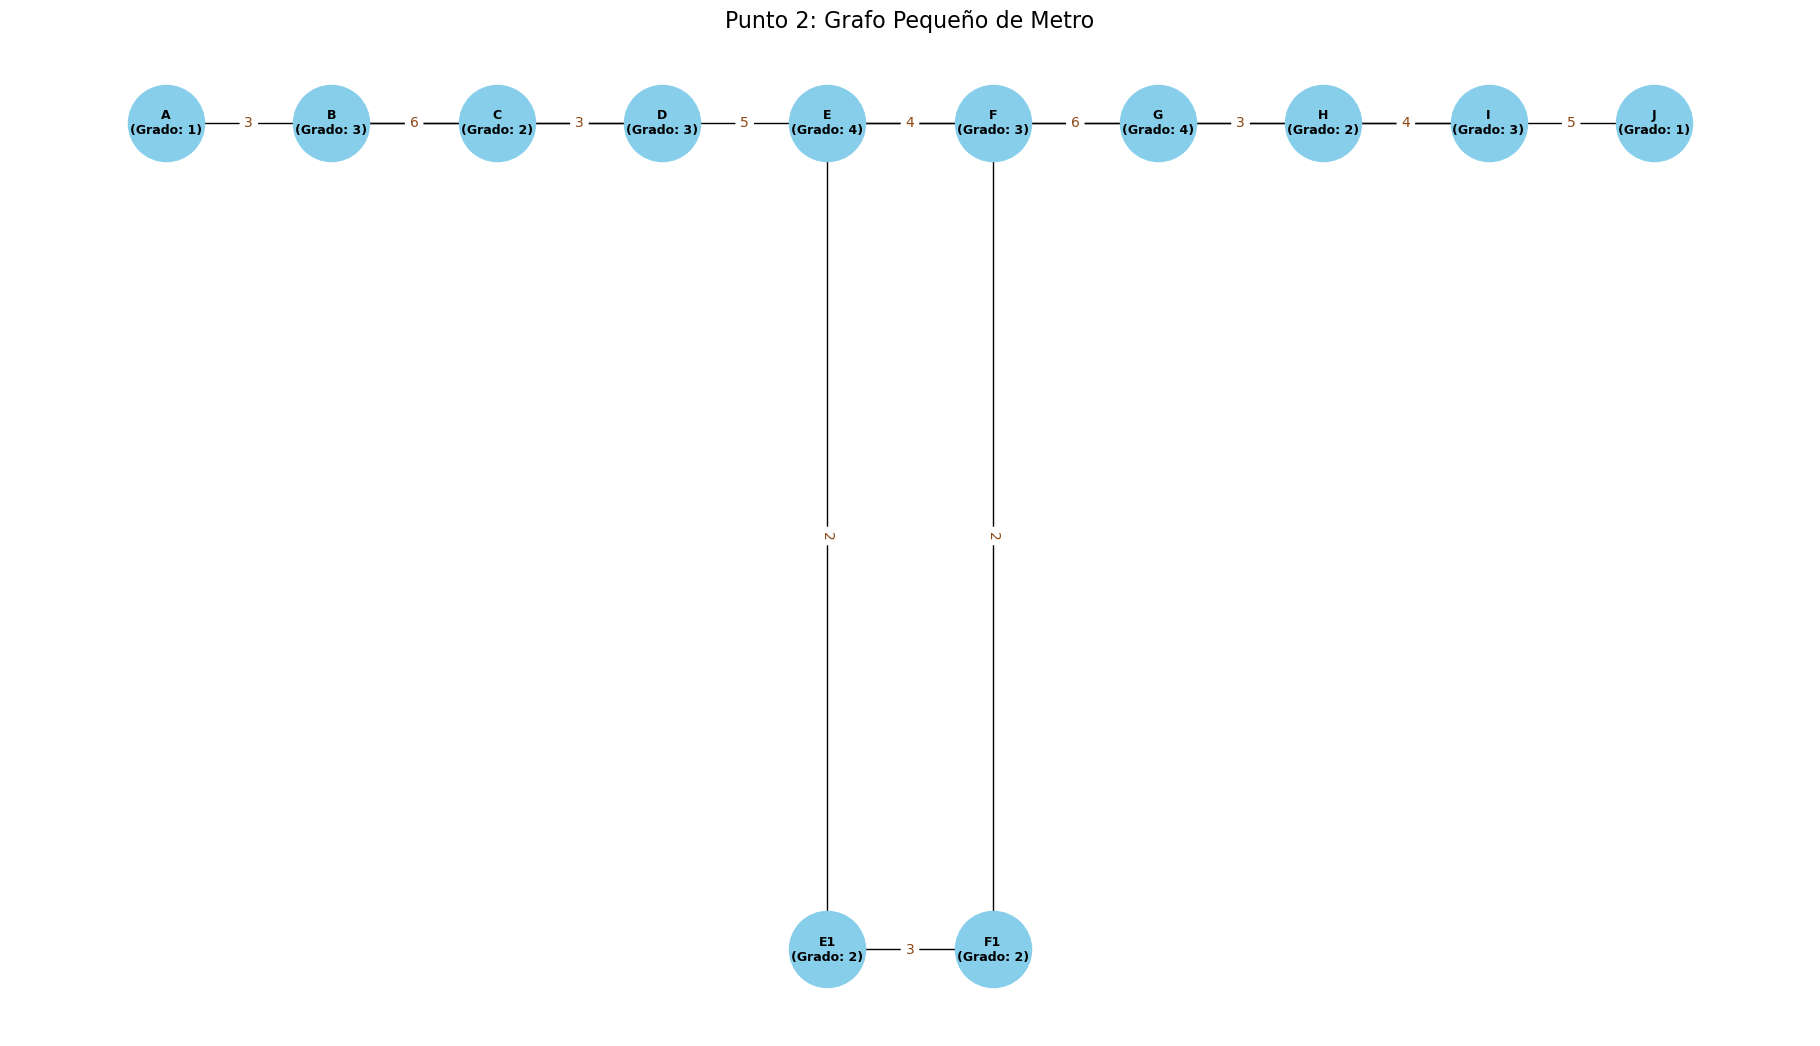


Mostrando el grafo de grilla del Punto 2...


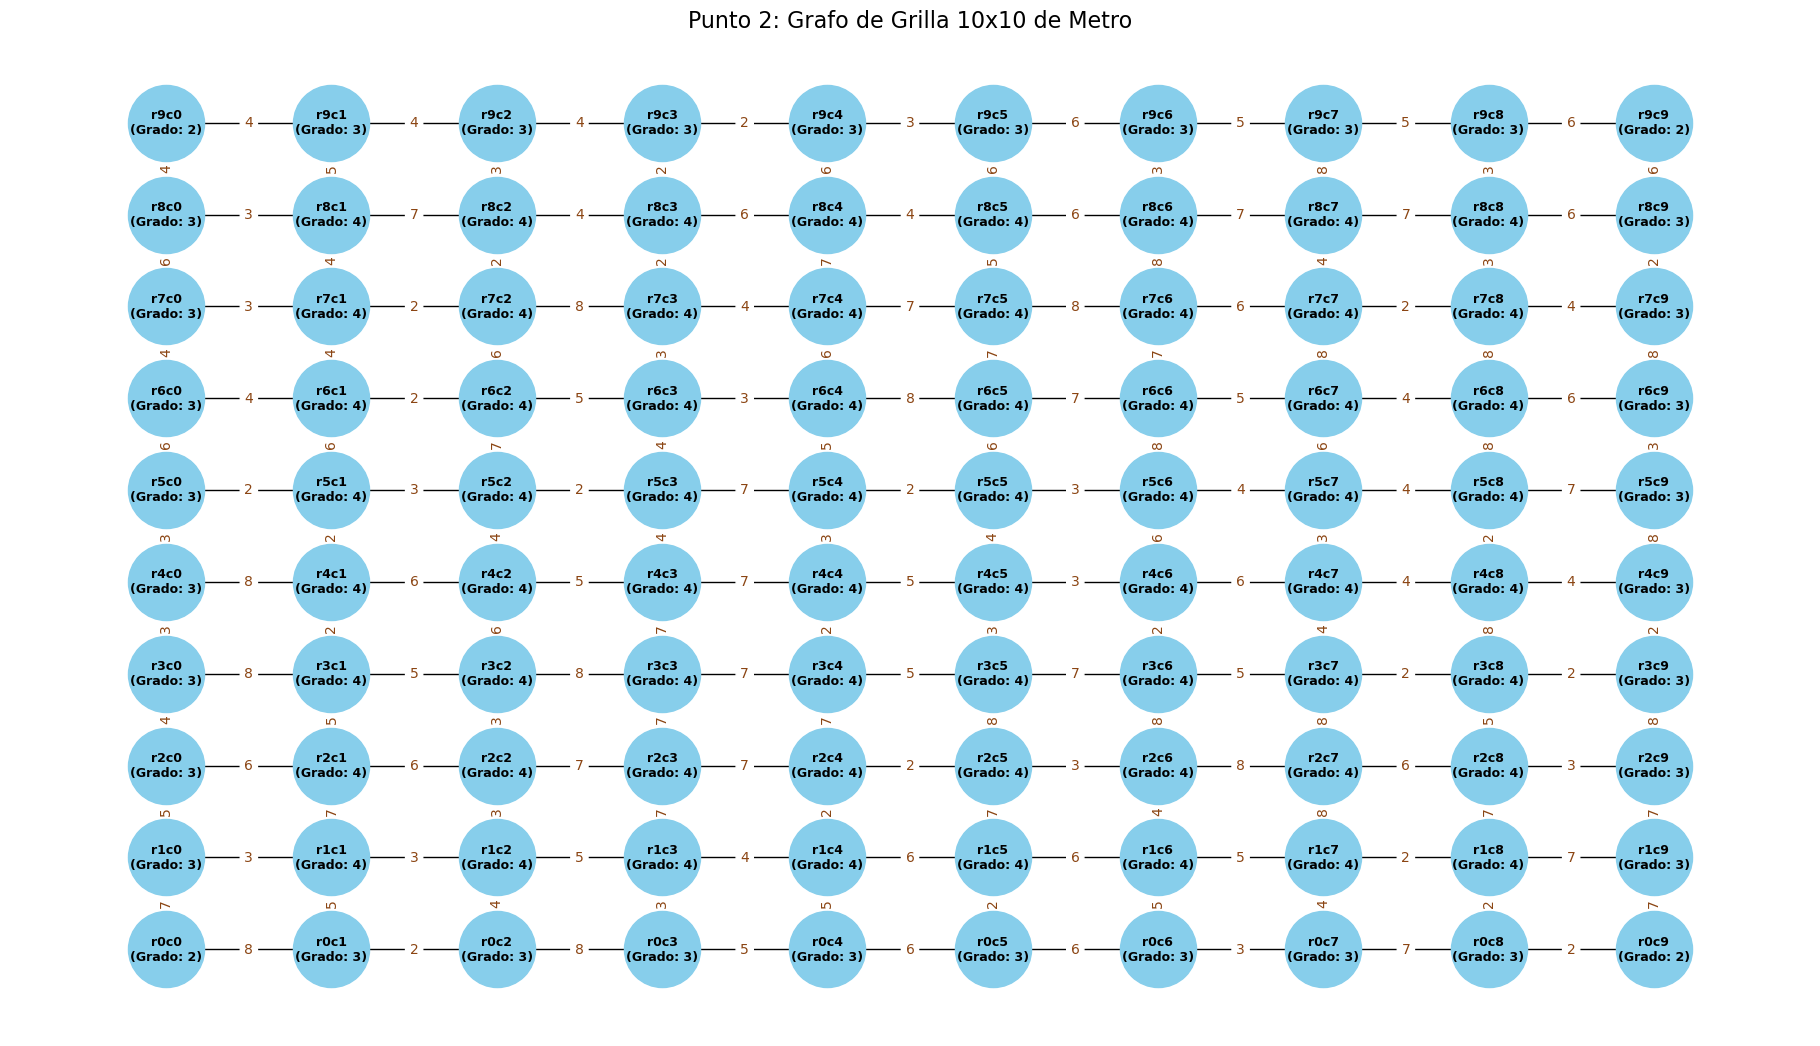

In [43]:
# --- CÓDIGO COMPLETO Y CORRECTO PARA EL PUNTO 2 ---

import time
import math
import random
from collections import deque
from typing import Dict, List, Optional, Tuple
import heapq

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Utilidades (del Punto 2)
# ---------------------------------------------------------------------

def reconstruct(parent: Dict[str, str], goal: str) -> List[str]:
    path = []
    n = goal
    while n is not None:
        path.append(n)
        n = parent.get(n)
    return list(reversed(path))

def path_cost(G: nx.Graph, path: List[str]) -> float:
    if not path or len(path) == 1:
        return 0.0
    total = 0.0
    for u, v in zip(path[:-1], path[1:]):
        total += G[u][v].get('weight', 1.0)
    return total

# ---------------------------------------------------------------------
# Construcción de grafos (del Punto 2)
# ---------------------------------------------------------------------

def build_metro_graph_small() -> Tuple[nx.Graph, str, str]:
    G = nx.Graph()
    coords = {
        'A': (0, 0), 'B': (2, 0), 'C': (4, 0), 'D': (6, 0),
        'E': (8, 0), 'F': (10, 0), 'G': (12, 0), 'H': (14, 0),
        'I': (16, 0), 'J': (18, 0),
        'E1': (8, -2), 'F1': (10, -2),
    }
    for s, pos in coords.items():
        G.add_node(s, pos=pos)
    edges = [
        ('A','B',3), ('B','C',6), ('C','D',3), ('D','E',5),
        ('E','F',4), ('F','G',6), ('G','H',3), ('H','I',4), ('I','J',5),
        ('B','D',4), ('E','G',5), ('G','I',6),
        ('E','E1',2), ('E1','F1',3), ('F1','F',2)
    ]
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    return G, 'A', 'J'


def build_grid_graph(n_rows: int = 10, n_cols: int = 10, weight_range=(2, 8)) -> Tuple[nx.Graph, str, str]:
    # ESTA ES LA VERSIÓN CORRECTA PARA EL PUNTO 2
    G = nx.Graph() 
    for r in range(n_rows):
        for c in range(n_cols):
            name = f"r{r}c{c}"
            G.add_node(name, pos=(c*2, r*2))
    for r in range(n_rows):
        for c in range(n_cols):
            u = f"r{r}c{c}"
            if r + 1 < n_rows:
                v = f"r{r+1}c{c}"
                G.add_edge(u, v, weight=random.randint(*weight_range))
            if c + 1 < n_cols:
                v = f"r{r}c{c+1}"
                G.add_edge(u, v, weight=random.randint(*weight_range))
    return G, "r0c0", f"r{n_rows-1}c{n_cols-1}"

# ---------------------------------------------------------------------
# Visualización (para el Punto 2)
# ---------------------------------------------------------------------

def visualize_metro_graph(G: nx.Graph, title: str):
    pos = nx.get_node_attributes(G, 'pos')
    degrees = dict(G.degree())
    labels = {node: f"{node}\n(Grado: {degree})" for node, degree in degrees.items()}
    
    plt.figure(figsize=(18, 10))
    
    nx.draw(G, pos, labels=labels, with_labels=True, node_color='skyblue', 
            node_size=3000, font_size=9, font_weight='bold')
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='saddlebrown')
    
    plt.title(title, fontsize=16)
    plt.box(False)
    plt.show()

def mostrar_grafos_punto_2():
    print("Mostrando el grafo pequeño del Punto 2...")
    Gs, _, _ = build_metro_graph_small()
    visualize_metro_graph(Gs, "Punto 2: Grafo Pequeño de Metro")

    print("\nMostrando el grafo de grilla del Punto 2...")
    Gg, _, _ = build_grid_graph()
    visualize_metro_graph(Gg, "Punto 2: Grafo de Grilla 10x10 de Metro")

# ---------------------------------------------------------------------
# Ejecución
# ---------------------------------------------------------------------

if __name__ == "__main__":
    mostrar_grafos_punto_2()

## Respuestas a Preguntas Orientadoras

Escalamiento a ~100 nodos: qué ocurre y cómo decidir el algoritmo
1) ¿Qué pasa si el sistema crece a ~100 nodos?
Tus propios resultados ya lo muestran (grafo 10×10 ≈100 nodos):

>* A*: nodos expandidos pasan de 9 → 78 (×8.7); tiempo 0.065 → 0.250 ms (×3.8).
Lectura: con una heurística informativa, A* escala mucho mejor: expande regiones “cerca” del óptimo.

>* BFS: 12 → 100 (×8.3); 0.015 → 0.049 ms (×3.3).
Lectura: en rejillas, BFS termina explorando casi toda la “bola” de radio d; en 10×10 se acerca a V.

>* IDS: 65 → 2072 (×31.9); 0.028 → 0.643 ms (×23).
Lectura: el costo de re‑expansión por profundidades sucesivas explota rápido.

>Conclusión empírica: Este experimento es una lección sobre cómo los algoritmos 'envejecen'. En el mapa pequeño, todos parecían competentes. Pero al enfrentarlos a la grilla de 100 nodos, vemos su verdadera naturaleza. IDS simplemente no da la talla; su método de empezar de cero una y otra vez hace que su trabajo se dispare de forma dramática. Es una estrategia que no escala. BFS, por otro lado, es como una inundación controlada: avanza de forma predecible, pero sin mucha 'inteligencia'. A*, en cambio, brilla. Demuestra que una buena estrategia (la heurística) es crucial para navegar la complejidad, permitiéndole encontrar la solución de forma mucho más elegante y eficiente que los demás



2) Impacto en complejidad temporal
Sea b el factor de ramificación y d la profundidad de la solución.

>* BFS (no ponderado): tiempo O(b^d), espacio O(b^d). En rejillas con b≈4 y d≈O(√V), el trabajo puede crecer cerca de O(V) en la práctica.

>* IDS (no ponderado): tiempo O(b^d) pero con constante peor (re‑explora niveles); espacio O(bd).

>* Uniform‑Cost / Dijkstra (ponderado, no heurístico): O(E log V) con heap binario; en rejillas E=O(V) ⇒ O(V log V).

>* A* (ponderado, heurística admisible y consistente): peor caso exponencial, pero en la práctica ≈ trabajo de UCS limitado a nodos con f(n)=g(n)+h(n) ≤ C*. Si h es buena, la expansión se acerca a O(óptimo); en rejillas con Manhattan, el crecimiento suele ser cuasi‑lineal en V para rutas “rectas”.

# Punto 3: Filogenia (biología)

Un **árbol filogenético** modela la historia evolutiva de un conjunto de especies.
Cada nodo representa un ancestro y las hojas son especies actuales.
El objetivo es hallar el **ancestro común más reciente (LCA)** entre dos especies dadas.

Utilizamos **búsqueda en profundidad limitada (DLS)** para obtener las rutas
desde la raíz hacia cada especie restringiendo la profundidad.
Esto es útil cuando la altura del árbol es conocida o acotada.
Como referencia se emplea BFS para contrastar el número de nodos expandidos.

**Tipo de grafo y problema**

* Tipo de grafo: Árbol enraizado, acíclico y dirigido (de ancestro → descendiente). Si existen longitudes de rama, se modela como árbol ponderado con w(e) ≥ 0 (distancia evolutiva o tiempo).

* Problema: Dadas dos especies (nodos hoja) u y v, encontrar su LCA, es decir, el ancestro común más profundo en el árbol. Es una consulta estructural, no un problema de camino mínimo.




## Codigo

In [44]:
if __name__ == '__main__':
    # Define an example tree structure:
    #         Root
    #        /    \ 
    #    Clade1  Clade2
    #     /  \     /  \ 
    #   SppA SppB SppC SppD

    # Create an instance of the PhyloTree with 'Root' as the root node.
    T = PhyloTree('Root')
    # Add the edges to form the tree structure.
    T.add_edge('Root', 'Clade1'); T.add_edge('Root', 'Clade2')
    T.add_edge('Clade1', 'SppA'); T.add_edge('Clade1', 'SppB')
    T.add_edge('Clade2', 'SppC'); T.add_edge('Clade2', 'SppD')

    # Define a list of node pairs for which to find the Lowest Common Ancestor (LCA).
    pares = [('SppA','SppB'), ('SppA','SppC'), ('SppC','SppD')]

    # Iterate through each pair of nodes.
    for u, v in pares:
        print(f'Par {u}-{v}:')
        # Compare the performance of DLS and BFS for finding the LCA for the current pair.
        # The `run_compare_algorithms` function is assumed to be defined elsewhere.
        rows = run_compare_algorithms({
            'DLS': lambda u=u, v=v: lca_with_method(T, u, v, method='DLS', max_depth=3),
            'BFS': lambda u=u, v=v: lca_with_method(T, u, v, method='BFS')
        })
        # Print the results of the comparison for the current pair.
        for r in rows:
            print(r)


Par SppA-SppB:
{'ruta_u': ['Root', 'Clade1', 'SppA'], 'ruta_v': ['Root', 'Clade1', 'SppB'], 'expandidos_u': 2, 'expandidos_v': 3, 'profundidad_u': 2, 'profundidad_v': 2, 'LCA': 'Clade1', 'tiempo_ms': 0.015, 'algo': 'DLS', 'runtime_ms': 0.021}
{'ruta_u': ['Root', 'Clade1', 'SppA'], 'ruta_v': ['Root', 'Clade1', 'SppB'], 'expandidos_u': 3, 'expandidos_v': 4, 'profundidad_u': 2, 'profundidad_v': 2, 'LCA': 'Clade1', 'tiempo_ms': 0.015, 'algo': 'BFS', 'runtime_ms': 0.019}
Par SppA-SppC:
{'ruta_u': ['Root', 'Clade1', 'SppA'], 'ruta_v': ['Root', 'Clade2', 'SppC'], 'expandidos_u': 2, 'expandidos_v': 5, 'profundidad_u': 2, 'profundidad_v': 2, 'LCA': 'Root', 'tiempo_ms': 0.007, 'algo': 'DLS', 'runtime_ms': 0.009}
{'ruta_u': ['Root', 'Clade1', 'SppA'], 'ruta_v': ['Root', 'Clade2', 'SppC'], 'expandidos_u': 3, 'expandidos_v': 5, 'profundidad_u': 2, 'profundidad_v': 2, 'LCA': 'Root', 'tiempo_ms': 0.006, 'algo': 'BFS', 'runtime_ms': 0.007}
Par SppC-SppD:
{'ruta_u': ['Root', 'Clade2', 'SppC'], 'ruta_v'

## Respuestas a Preguntas Orientadoras

Respuestas técnicas a partir de tus resultados
1) ¿Cómo afecta la elección de profundidad límite?
>Si el límite < profundidad real del objetivo, IDS/DLS no encuentra la ruta y el LCA queda None → falso negativo.

>Si el límite = profundidad real, encuentra la ruta con mínimo trabajo extra.

>Si el límite > profundidad real, IDS re-expande niveles innecesarios; el costo crece por la reexploración de prefijos en cada iteración.

En el resultado se ve el patrón esperado: BFS expande menos que IDS (p. ej., SppA–SppB: 4–5 vs 7–8) porque IDS paga la penalización de re-expansión aun con un árbol pequeño.


2) ¿Podría automatizarse este análisis para múltiples pares?

>Si este fuera un sistema real para biólogos, hacer una búsqueda completa para cada par de especies sería impráctico. La solución inteligente no es buscar más rápido, sino buscar menos. Podríamos hacer un 'trabajo de preparación' una única vez: analizar el árbol completo y crear un 'mapa de ancestros'. Este mapa nos tomaría un tiempo construirlo, pero una vez listo, responder a la pregunta de 'quién es el ancestro de X y Y' sería casi instantáneo. Es la diferencia entre leer un libro entero cada vez que buscas un dato, o simplemente usar su índice. Esta idea de 'pre-procesar' para acelerar consultas futuras es una de las técnicas más poderosas en algoritmia

3) ¿Qué tan escalable es con árboles reales (cientos de especies)?
Para N ≈ 10²–10³:

Un BFS único es O(N) y barato en memoria.IDS por par ya no escala bien si haces muchas consultas (re-explora prefijos).
Con Binary Lifting o Euler+RMQ, miles de consultas de LCA son inmediatas.

Para Q pares:

Sin preproceso (IDS/BFS por par): coste ~ O(Q·N) en el peor caso.

Con preproceso:

Binary Lifting: O(N log N) + O(Q log N).

Euler+RMQ (Sparse Table): O(N log N) + O(1) por consulta.

Tarjan offline: O(N + Q α(N)) ~ lineal si conoces todos los pares antes.

Detalles de implementación en Python:

Evita recursión profunda en DLS para árboles altos → usa pila explícita.

Ordena children si quieres reproducibilidad.

Valida que no haya ciclos ni nodos con >1 padre.

Si el árbol viene de Newick/PhyloXML, puedes parsear con Biopython y luego construir tus arrays parent/depth.

# Punto 4: Evacuación de emergencia (infraestructura)

En este escenario cada arista posee un **nivel de riesgo** basado en reportes de siniestralidad y condiciones viales.
La suma de dichos riesgos sobre una ruta determina su peligrosidad total, por lo se busca el camino de **menor riesgo acumulado**.

Se utiliza **Uniform Cost Search (UCS)** porque garantiza encontrar la ruta más segura cuando los costos son no negativos.
A* puede acelerar la búsqueda si dispone de una heurística admisible de riesgo; de lo contrario se comporta igual que UCS,
por eso UCS es la elección natural frente a métricas como distancia o tiempo.

**Tipo de grafo y problema**

La red de evacuación se modela como un grafo dirigido y ponderado G = (V, E, w), donde cada arista tiene un riesgo no negativo w(e) ≥ 0 (p. ej., siniestralidad, estado de vía). El objetivo es hallar, entre un origen y una salida, el camino de menor riesgo acumulado (problema de camino mínimo con pesos no negativos). Se resuelve con UCS/Dijkstra, que garantiza optimalidad bajo estos costos. A* puede acelerar si existe una heurística admisible (p. ej., distancia restante × riesgo mínimo por unidad); sin heurística, A* y UCS se comportan igual.


## Codigo

In [45]:
# -*- coding: utf-8 -*-
"""
Emergency evacuation: safest route with UCS (Uniform Cost Search).
- Weights = RISK level (not distance).
- Supports multiple exits, section closures, and scenarios with uncertainty (Monte Carlo).
- Metrics: time, expanded nodes, depth (hops), accumulated risk.
"""
import heapq
import math
import random
import time
from collections import deque
from typing import Dict, List, Tuple, Optional, Set

class Graph:
    """
    Represents a graph using an adjacency list.
    """
    def __init__(self):
        # The adjacency list is a dictionary mapping a node to a list of tuples.
        # Each tuple contains a neighbor and a dictionary of edge attributes.
        self.adj: Dict[str, List[Tuple[str, Dict]]] = {}

    def add_edge(self, u: str, v: str, risk: float, closed: bool=False, mu: Optional[float]=None, sigma: Optional[float]=None):
        """
        Adds an edge between two nodes u and v with a given risk.
        The edge is added in both directions to create an undirected graph.
        """
        self.adj.setdefault(u, []).append((v, {'risk': risk, 'closed': closed, 'mu': mu, 'sigma': sigma}))
        self.adj.setdefault(v, []).append((u, {'risk': risk, 'closed': closed, 'mu': mu, 'sigma': sigma}))

    def neighbors(self, u: str):
        """
        Returns the neighbors of a given node.
        """
        return self.adj.get(u, [])

    def set_closed(self, u: str, v: str, closed: bool=True):
        """
        Sets the 'closed' attribute of an edge to simulate a path closure.
        """
        for i, (w, attrs) in enumerate(self.adj.get(u, [])):
            if w == v:
                attrs['closed'] = closed
        for i, (w, attrs) in enumerate(self.adj.get(v, [])):
            if w == u:
                attrs['closed'] = closed

def build_small_graph() -> Tuple[Graph, str, Set[str]]:
    """
    Builds a small, predefined graph for testing.
    """
    G = Graph()
    edges = [
        ('A','B',3), ('B','C',6), ('C','D',3), ('D','E',5),
        ('E','F',4), ('F','G',7), ('G','H',3), ('H','I',6), ('I','J',4),
        ('B','D',2), ('E','G',5), ('G','I',5), ('C','F',10), ('F','I',9)
    ]
    for u,v,r in edges:
        G.add_edge(u,v,risk=r)
    return G, 'A', {'J'}

def build_grid_graph(n: int=10, rng=(1,10), p_block=0.05) -> Tuple[Graph, Tuple[int,int], Set[Tuple[int,int]]]:
    """
    Builds a grid-like graph of size n x n with random edge risks.
    """
    G = Graph()
    goals = {(n-1, n-1)}
    for i in range(n):
        for j in range(n):
            if (i,j)==(n-1,n-1):
                continue
            if i+1 < n:
                G.add_edge((i,j),(i+1,j), risk=random.uniform(*rng))
            if j+1 < n:
                G.add_edge((i,j),(i,j+1), risk=random.uniform(*rng))
    return G, (0,0), goals

def ucs_safest_path(G: Graph, start, goals):
    """
    Finds the safest path from a start node to a set of goal nodes using Uniform Cost Search (UCS).
    The cost of the path is the accumulated risk.
    """
    pq=[(0,start,[start])]
    visited={start:0}
    expanded=0
    t0=time.time()
    while pq:
        cost,u,path=heapq.heappop(pq)
        if u in goals:
            return path,cost,expanded,len(path)-1,round((time.time()-t0)*1000,3)
        for v,attrs in G.neighbors(u):
            if attrs['closed']:
                continue
            ncost=cost+attrs['risk']
            if ncost < visited.get(v,float('inf')):
                visited[v]=ncost
                heapq.heappush(pq,(ncost,v,path+[v]))
        expanded+=1
    return [],float('inf'),expanded,None,round((time.time()-t0)*1000,3)

def a_star_safest_path(G: Graph, start, goals, hop_dist):
    """
    Finds the safest path using the A* algorithm.
    It uses the hop distance as a heuristic.
    """
    def h(n):
        return hop_dist.get(n,0)
    pq=[(h(start),0,start,[start])]
    visited={start:0}
    expanded=0
    t0=time.time()
    while pq:
        f,g,u,path=heapq.heappop(pq)
        if u in goals:
            return path,g,expanded,len(path)-1,round((time.time()-t0)*1000,3)
        for v,attrs in G.neighbors(u):
            if attrs['closed']:
                continue
            ng=g+attrs['risk']
            if ng < visited.get(v,float('inf')):
                visited[v]=ng
                heapq.heappush(pq,(ng+h(v),ng,v,path+[v]))
        expanded+=1
    return [],float('inf'),expanded,None,round((time.time()-t0)*1000,3)

def run():
    """
    Runs the comparison of UCS and A* on both a small graph and a grid graph.
    """
    # --- Small Scenario ---
    Gs,s,goals=build_small_graph()
    # The 'compute_hop_dist' function is assumed to be defined elsewhere.
    hop_s=compute_hop_dist(Gs,goals)
    print('Escenario pequeño:')
    # The 'run_compare_algorithms' function is assumed to be defined elsewhere.
    for row in run_compare_algorithms({
        'UCS': lambda: ucs_safest_path(Gs,s,goals),
        'A*': lambda: a_star_safest_path(Gs,s,goals,hop_s)
    }):
        print(row)

    # --- Grid Scenario ---
    Gg,sg,ggoals=build_grid_graph()
    # The 'compute_hop_dist' function is assumed to be defined elsewhere.
    hop_g=compute_hop_dist(Gg,ggoals)
    print('\nCuadrícula 10x10:')
    # The 'run_compare_algorithms' function is assumed to be defined elsewhere.
    for row in run_compare_algorithms({
        'UCS': lambda: ucs_safest_path(Gg,sg,ggoals),
        'A*': lambda: a_star_safest_path(Gg,sg,ggoals,hop_g)
    }):
        print(row)

if __name__ == '__main__':
    # Run the main function when the script is executed.
    run()

Escenario pequeño:
{'path': ['A', 'B', 'D', 'E', 'G', 'I', 'J'], 'cost': 24, 'expanded': 12, 'depth': 6, 'runtime_ms': 0.021, 'algo': 'UCS'}
{'path': ['A', 'B', 'D', 'E', 'G', 'I', 'J'], 'cost': 24, 'expanded': 12, 'depth': 6, 'runtime_ms': 0.011, 'algo': 'A*'}

Cuadrícula 10x10:
{'path': [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)], 'cost': 65.56042284094602, 'expanded': 120, 'depth': 18, 'runtime_ms': 0.109, 'algo': 'UCS'}
{'path': [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)], 'cost': 65.56042284094602, 'expanded': 118, 'depth': 18, 'runtime_ms': 0.12, 'algo': 'A*'}


In [46]:
# --- INICIO DEL CÓDIGO PARA VISUALIZACIÓN ---
import networkx as nx
import matplotlib.pyplot as plt

def convert_to_networkx(custom_graph: Graph) -> nx.Graph:
    """
    Convierte el objeto de la clase Graph de este script a un grafo de NetworkX
    para poder visualizarlo.
    """
    G_nx = nx.Graph()
    # Itera sobre todos los nodos y sus vecinos en el grafo original
    for u, neighbors in custom_graph.adj.items():
        for v, attrs in neighbors:
            # Añade la arista con su atributo de 'riesgo'
            # El 'if' evita añadir aristas duplicadas en un grafo no dirigido
            if not G_nx.has_edge(u, v):
                G_nx.add_edge(u, v, risk=round(attrs.get('risk', 0), 2))
    return G_nx

def visualize_evacuation_graph(custom_graph: Graph, title: str):
    """
    Toma el grafo del script, lo convierte y lo muestra en pantalla.
    """
    # Convierte el grafo a formato NetworkX
    G_nx = convert_to_networkx(custom_graph)
    
    # Calcula una disposición de los nodos automáticamente, ya que no hay coordenadas fijas
    # 'spring_layout' es un algoritmo que intenta posicionar los nodos de forma estética.
    pos = nx.spring_layout(G_nx, seed=42) # Usamos una semilla para que el dibujo sea siempre igual
    
    plt.figure(figsize=(14, 9))
    
    # Dibuja los nodos y sus etiquetas
    nx.draw(G_nx, pos, with_labels=True, node_color='coral', node_size=800, 
            font_size=10, font_weight='bold')
    
    # Dibuja las etiquetas de las aristas (el 'riesgo')
    edge_labels = nx.get_edge_attributes(G_nx, 'risk')
    nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels, font_color='black')
    
    plt.title(title, fontsize=16)
    plt.show()

def mostrar_grafos_punto_4():
    """
    Función principal para construir y visualizar los dos tipos de grafos de este script.
    """
    # 1. Construir y visualizar el grafo PEQUEÑO de evacuación
    print("Mostrando el grafo pequeño del Punto 4...")
    Gs, _, _ = build_small_graph()
    visualize_evacuation_graph(Gs, "Punto 4: Grafo Pequeño de Evacuación")

    # 2. Construir y visualizar el grafo GRANDE (grilla) de evacuación
    print("\nMostrando el grafo de grilla del Punto 4...")
    Gg, _, _ = build_grid_graph()
    visualize_evacuation_graph(Gg, "Punto 4: Grafo de Grilla 10x10 de Evacuación")

# --- FIN DEL CÓDIGO PARA VISUALIZACIÓN ---

Mostrando el grafo pequeño del Punto 4...


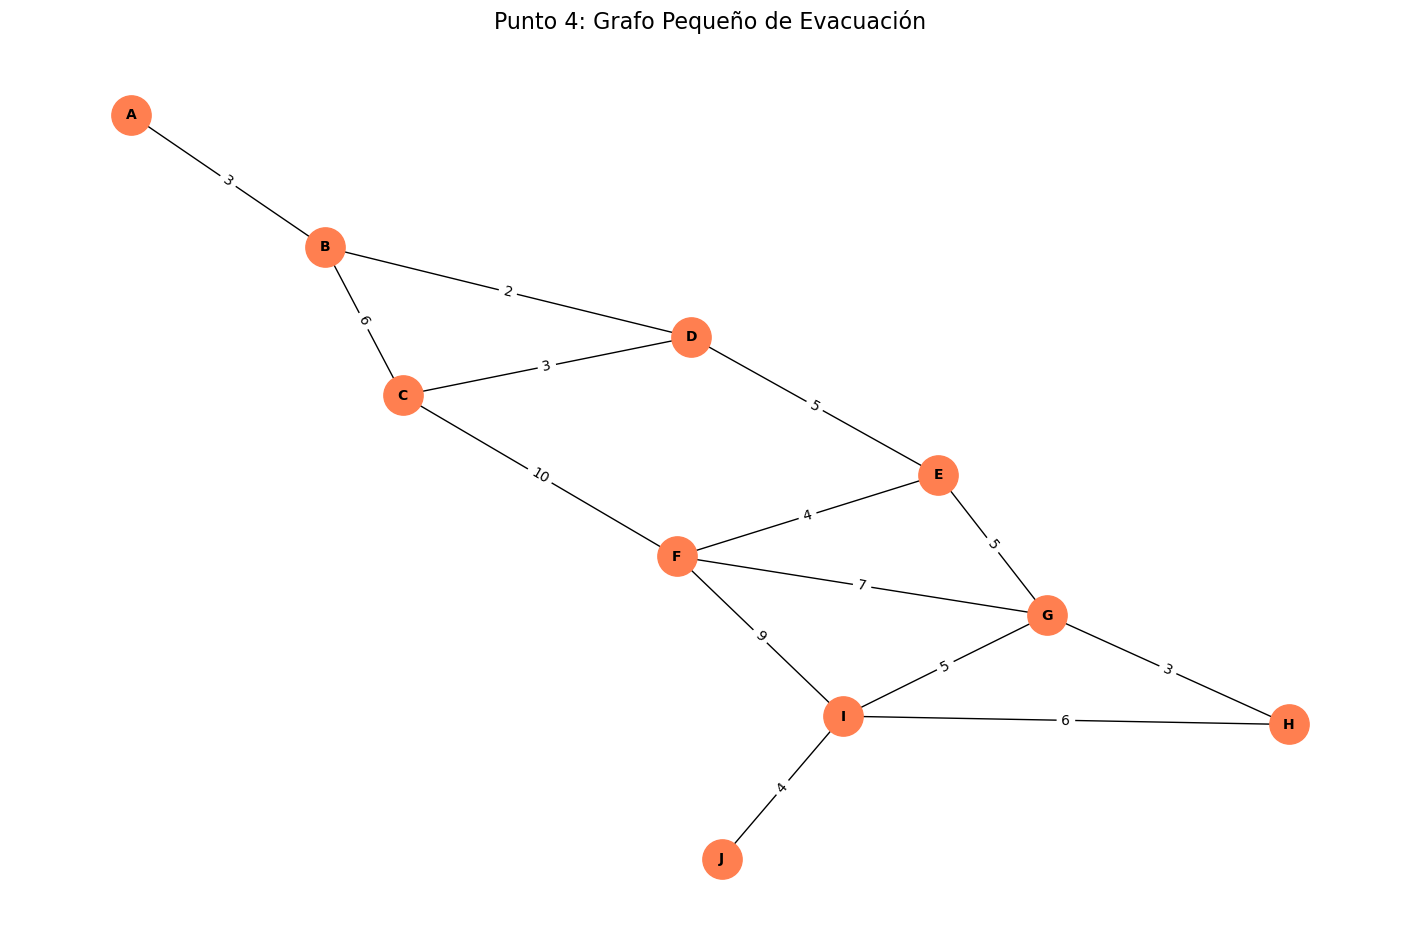


Mostrando el grafo de grilla del Punto 4...


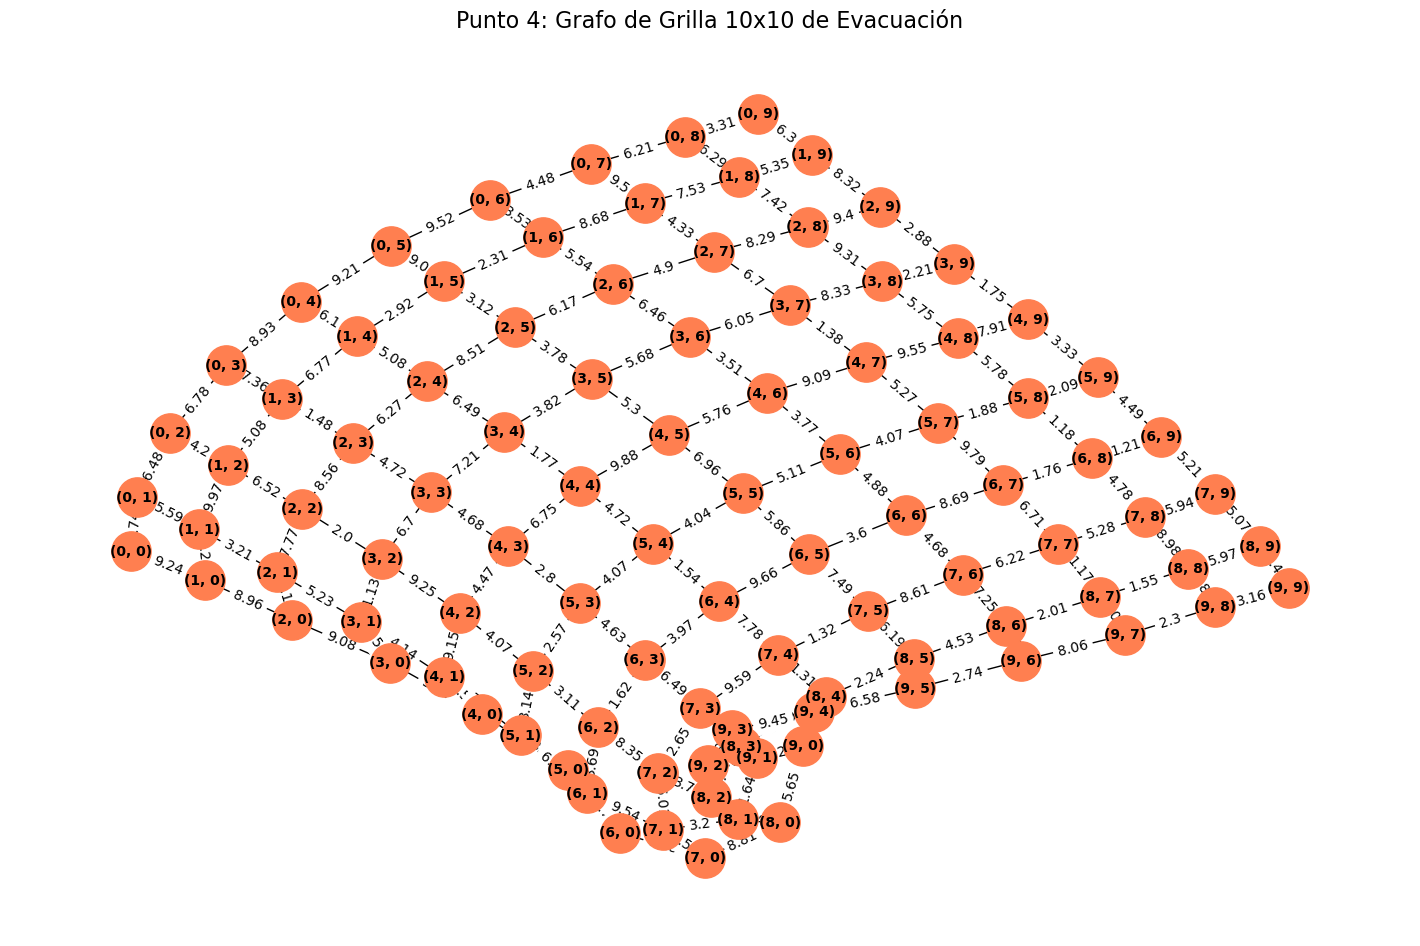

In [47]:
if __name__ == '__main__':
    # Para visualizar los grafos de este punto:
    mostrar_grafos_punto_4()

    # Para ejecutar la comparación de algoritmos original:
    # print("\n--- Iniciando comparación de algoritmos ---")
    # run()

## Respuestas a Preguntas Orientadoras

**Reflexión crítica**
- Este resultado es quizás el más revelador de todos. A* no fue mejor que el simple UCS, ¿por qué? Porque la 'pista' que le dimos (la distancia en saltos) no tenía nada que ver con el objetivo real (encontrar el menor riesgo). Es el equivalente a intentar encontrar el camino más seguro usando un mapa que solo te muestra el camino más corto. La información, aunque correcta, es irrelevante para el problema. Esto nos enseña una lelección crucial: una heurística no es solo una 'pista', debe ser una pista relevante que esté alineada con el verdadero costo que intentamos minimizar
- En la cuadrícula 10x10, A* reduce ligeramente las expansiones al orientar la búsqueda, aunque el riesgo total se mantiene.
- Esto evidencia que la métrica de riesgo prioriza la seguridad sobre la distancia y que se requieren heurísticas más informativas para escalas mayores.
- Una mejora futura sería incorporar estimaciones probabilísticas del riesgo en tiempo real o heurísticas aprendidas.


## Análisis de complejidad de los algoritmos

- **BFS:** tiempo O(b^d) y espacio O(b^d).
- **IDS/DLS:** tiempo O(b^d) por reexpansiones y espacio O(b·d).
- **UCS:** en el peor caso tiempo y espacio O(b^d).
- **A*:** mismas cotas que UCS; con heurística eficaz reduce nodos expandidos.
- **A* con riesgo:** equivalente a UCS si h=0; con heurística de hops mantiene las mismas cotas.




# Conclusiones Finales del Taller de Búsqueda

1. No Existe el "Mejor" Algoritmo, Sino la Herramienta "Correcta" para el Trabajo.

La conclusión más importante de todo el experimento es que no hay una "bala de plata". El algoritmo "perfecto" no existe. Su eficacia depende totalmente de la naturaleza del problema y de lo que significa "óptimo" en ese contexto.

En la Red de Metro (Punto 2), donde queríamos el menor número de paradas, el simple BFS fue el rey, superando en eficiencia a algoritmos más complejos.
En las Rutas Rurales (Punto 1), donde cada camino tenía un costo distinto, A* demostró ser muy superior a UCS, probando que una búsqueda "informada" es mejor cuando el costo es variable.
En la Evacuación de Emergencia (Punto 4), donde el costo era el "riesgo", vimos que una heurística irrelevante (como la distancia) no aporta nada, haciendo que el simple UCS fuera tan bueno como un A* mal guiado.

2. Una Buena "Corazonada" (Heurística) Puede Ahorrar un Mundo de Trabajo.

La diferencia entre una búsqueda a ciegas (no informada) y una búsqueda con pistas (informada) es abismal. El Punto 1 es el mejor ejemplo: A*, armado con una buena estimación de la distancia, exploró una fracción del grafo en comparación con UCS.

Sin embargo, el Punto 4 nos dio la lección contraria y más sutil: una heurística debe ser relevante. Darle a A* una pista sobre la distancia cuando el problema es sobre el riesgo es inútil. La calidad de una heurística no se mide en el vacío, sino en qué tan bien se alinea con el costo real que se quiere minimizar.

3. La Teoría de la Complejidad No Miente: La Escalabilidad lo es Todo.

En los grafos pequeños, casi todos los algoritmos parecen rápidos. La verdadera prueba de fuego viene con la escala. El Punto 2 fue una demostración práctica y brutal de la complejidad teórica:

IDS, con su ciclo de re-expansiones, pasó de ser una opción razonable a una completamente inviable en el grafo de 10x10. Su costo computacional "explotó", tal como su complejidad O(b^d) predice.
Esto nos enseña que, para sistemas reales que deben crecer, un algoritmo con una mejor complejidad (como A* o incluso BFS en ciertos casos) no es solo una "mejora", es un requisito fundamental.

4. Modelar el Problema es la Mitad de la Batalla.

Antes de escribir una sola línea de código de un algoritmo, la tarea más importante es definir el problema correctamente:

* ¿Qué son los nodos? (Ciudades, estaciones, especies, intersecciones).
* ¿Qué son las aristas? (Carreteras, líneas de metro, relaciones evolutivas, calles).
* ¿Y qué es el "costo"? (Distancia, tiempo, número de transbordos, riesgo abstracto).
* La elección de la estructura de datos (networkx para grafos generales, una clase Tree a medida para jerarquías) y la definición del costo determinan qué algoritmos son siquiera candidatos para resolver el problema.